# Estratégia de modelagem
* Na descrição da atividade foi definido como objetivo principal "queremos que você treine e avalie um modelo de Machine Learning para fazer a estimação da variável Next_Tmax, explicando a qualidade do modelo a partir das métricas de avaliação utilizadas". O conjunto de dados contém a temperatura do dia corrente "Present_Tmax", uma série de variáveis que auxiliam em um modelo de previsão, e uma chamada "Next_Tmax" - que é a previsão do dia seguinte realizada pelo modelo que originou esse conjunto de dados.
* É natural que não faça sentido sob nenhuma ótica criar um modelo que mire a previsão de outro modelo (Next_Tmax), e sim a saída futura de um fenômeno natural (Present_Tmax do dia seguinte).
* Desse modo, a estratégia de modelagem que irei adotar é a previsão da coluna "Present_Tmax" com o shift de um dia (ou seja, o valor da temperatura máxima do dia seguinte ao que estou observando).
* Como forma de avaliação do desempenho do modelo gerado nesse projeto irei observar três estratégias:
    1. Medição de desempenho de regressão: R^2 e RMSE. São métricas que são utilizadas de forma clássica para aferição de desempenho de regressores, e são as que fazem maior sentido para o objetivo delineado acima.
    2. Medição comparativa com modelo original: Acurácia. Adotarei um critério binário onde irei comparar o módulo da diferença entre a previsão pontual (point forecast) do modelo original (Next_Tmax) em relação à temperatura real do dia seguinte (Present_Tmax_shift1) com o módulo da diferença entre a minha previsão (pred) em relação à temperatura real do dia seguinte (Present_Tmax_shift1). A acurácia será medida pela quantidade de vezes em que o modelo proposto (pred) foi melhor que o modelo original (Next_Tmax) em relação ao total de instâncias do conjunto de dados de teste.
    3. Medição de desempenho de classificação: Precisão e revocação. Para que haja a viabilidade de uma medida de classificação é necessário que exista uma matriz de confusão. Desse modo, o resultado do regressor será convertido em uma saída em classificação binária que responde à seguinte pergunta: a máxima do próximo dia será superior à máxima do dia corrente? E as predições serão comparadas aos valores reais (Verdadeiro/Falso) de modo a gerar a matriz de confusão correspondente e, consequentemente, as medidas de precisão e revocação.
    
* O que *não* será levado em consideração nesse projeto, e por quê:
    * Não será feita uma classificação de múltiplos níveis, à partir da quantização dos valores de temperatura, que iriam gerar faixas de valores comparáveis entre predição e realizado, de modo a ter um resultado classificatório. Essa possibilidade foi descartada pois a largura das faixas de valores seria muito arbitrária, e facilmente manipulável no sentido de se gerar um resultado pretensamente mais adequado.
    * Reforçando, *não* será também gerada uma previsão baseada no objetivo de se atingir o valor constante em (Next_Tmax), uma vez que este é o valor de saída de um outro modelo. De modo que não faria sentido, ao menos nesse contexto, tentar criar um modelo que crie uma representação multi-dimensional de um outro modelo existente.
    
* Nota adicional (1): Foi observado o paper que originou esse conjunto de dados (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019EA000740) para melhor entendimento de suas características.
* Nota adicional (2): Para todo processo de modelagem foi utilizada a biblioteca pycaret, e em muitos momentos o tutorial de regressão (https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Intermediate%20-%20REG102.ipynb) foi copiado, modificado ou usado como inspiração.

In [1]:
import pandas as pd
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, precision_score, recall_score

# Pré-processamento
* Antes de iniciar a modelagem iremos:
    * Gerar a variável de interesse (Shifted_Tmax)
    * Converter a coluna de data para formato de data reconhecido pelo pandas
    * Eliminar linhas que possuem quaisquer dados nulos (pudemos ver no EDA que não são poucos casos)
    * Gerar um conjunto de dados "unseen", que será utilizado para testar o desempenho do modelo *a posteriori*

In [2]:
df = pd.read_csv('./../data/raw/bias_correction_ucl.csv')
df['Shifted_Tmax'] = df.groupby(['station'])['Present_Tmax'].shift(-1)
df['Original_Model_Tmax'] = df.groupby(['station'])['Next_Tmax'].shift(-1)
df['Original_Model_Tmin'] = df.groupby(['station'])['Next_Tmin'].shift(-1)
df = df[~df.Shifted_Tmax.isnull()]
df.Date = pd.to_datetime(df.Date)
df = df[df.isnull().sum(axis=1)==0]

data = df.sample(frac=0.75, random_state=42)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (5631, 28)
Unseen Data For Predictions: (1877, 28)


# Configuração de dados na biblioteca Pycaret
* Iremos utilizar a biblioteca pycaret pois ela possui muitas funcionalidades pré-desenhadas no processo de modelagem, e se mostra uma excelente forma de criar um primeiro modelo produtível em curto espaço de tempo.
* No caso dessa configuração, estamos excluindo os resultados em ['Next_Tmax', 'Next_Tmin'], uma vez que vamos usar esses números para mensurar algumas das nossas métricas.
* Também estamos incluindo features polinomiais e trigonométricas, que são geradas a partir da relação entre diferentes features preexistentes (e.g., a multiplicação de duas features, a tangente de uma outra).
* O pycaret também reconhecerá a coluna de data como valores temporais e irá criar features associadas (e.g., dia da semana, mês do ano)
* Por fim, o parâmetro de "feature_selection" irá utilizar modelos baseados em árvore para verificar quais features possuem melhor poder preditivo em relação ao target, excluindo-se as demais. De modo a diminuir a quantidade de features (expandida pelas parametrização de polinomais e trigonométricas) e evitar que algumas features tenham impacto negativo sobre o resultado.

In [3]:
exp_reg101 = setup(
    data = data, 
    target = 'Shifted_Tmax', 
    fold_shuffle=True, 
    imputation_type='iterative', 
    ignore_features=['Next_Tmax', 'Next_Tmin', 'Original_Model_Tmax', 'Original_Model_Tmin'], 
    polynomial_features=True, 
    trigonometry_features=True, 
    feature_selection=True
)

,Description,Value
0,session_id,1449
1,Target,Shifted_Tmax
2,Original Data,"(5631, 28)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3941, 41)"


# Features resultantes
* A tabela abaixo apresenta as features resultantes (40) que serão utilizadas para treinamento do modelo preditivo. 
* Note como há features que foram extraídas da coluna de data, outras que são polinomiais/trigonométricas e outras que podem ter sido excluídas.
* Algumas features, por conhecimento do problema a ser resolvido, não guardam relação intrínseca com a coluna-alvo. Por exemplo, o dia da semana não deveria influenciar na temperatura observada, contudo a coluna "Date_weekday_3" foi selecionada pelo processo de feature selection. Um aprofundamento do processo de modelagem deveria investigar mais a fundo essa questão.

In [4]:
pd.options.display.max_columns = 100
xt = get_config('X_train')
xt

,LDAPS_PPT2,LDAPS_LH,LDAPS_CC2_Power2,Date_weekday_3,LDAPS_CC2,Present_Tmax_Power2,Date_weekday_1,Slope,lat,LDAPS_WS_Power2,Date_month_7,Date_weekday_2,tan(LDAPS_CC2),Date_is_month_start_0,LDAPS_RHmin_Power2,LDAPS_CC3,cos(LDAPS_CC3),LDAPS_RHmin,LDAPS_WS,lon,Solar radiation_Power2,Date_weekday_4,Date_is_month_end_1,Date_weekday_5,LDAPS_PPT4,LDAPS_Tmin_lapse,Date_weekday_6,Date_month_8,LDAPS_PPT1,LDAPS_RHmax,LDAPS_CC1_Power2,Present_Tmin_Power2,station,LDAPS_CC4,LDAPS_Tmax_lapse_Power2,LDAPS_PPT3,tan(LDAPS_CC3),LDAPS_CC1,Date_weekday_0,LDAPS_CC4_Power2,DEM
4044,0.000000,22.680595,0.007994,0.0,0.089410,985.959961,1.0,0.2713,37.523701,44.437519,0.0,0.0,0.089649,1.0,931.378479,0.000796,1.000000,30.518494,6.666147,126.970001,26207990.0,0.0,0.0,0.0,0.000000,23.949942,0.0,1.0,0.000000,79.063393,0.008861,660.490051,25.0,0.000000,1138.359863,0.000000,0.000796,0.094135,0.0,0.000000,19.584400
170,0.030129,69.287354,0.545393,0.0,0.738507,772.839966,0.0,5.1782,37.456200,31.430054,1.0,0.0,0.910356,1.0,1207.343262,0.195147,0.981019,34.746845,5.606251,126.955002,34306508.0,0.0,0.0,1.0,0.000000,22.014854,0.0,0.0,0.187399,86.637985,0.376726,412.089966,10.0,0.049591,817.938721,0.000000,0.197662,0.613780,0.0,0.002459,208.507004
3831,0.239379,39.055275,0.317370,0.0,0.563356,655.360046,0.0,0.8552,37.550701,26.829163,0.0,1.0,0.631635,1.0,2334.825684,0.396867,0.922276,48.320034,5.179688,126.936996,27853068.0,0.0,0.0,0.0,0.000000,22.510445,0.0,1.0,0.016211,94.175011,0.664127,457.959991,15.0,0.167171,847.354736,0.000625,0.419105,0.814940,0.0,0.027946,30.046400
5322,0.000000,50.244156,0.340328,0.0,0.583376,745.289978,0.0,1.5629,37.469700,92.992607,0.0,0.0,0.660004,1.0,4210.694336,0.684596,0.774674,64.889862,9.643268,126.910004,25532282.0,0.0,0.0,0.0,0.046098,22.442879,1.0,1.0,0.081894,80.048775,0.403606,590.489990,8.0,0.738650,665.168030,0.013621,0.816292,0.635300,0.0,0.545603,52.518002
3148,0.000000,114.551773,0.001758,0.0,0.041928,497.289978,0.0,4.7296,37.618099,141.927109,0.0,0.0,0.041952,1.0,2935.129883,0.205878,0.978882,54.176838,11.913317,127.003998,21106334.0,0.0,0.0,0.0,0.000000,16.354691,1.0,1.0,0.000000,84.559280,0.084131,309.760010,20.0,0.171110,572.478516,0.000000,0.208837,0.290054,0.0,0.029279,146.554001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.727650,41.000919,0.320333,1.0,0.565980,823.690063,0.0,2.6865,37.577599,26.879976,1.0,0.0,0.635311,1.0,5254.079590,0.798447,0.697820,72.485031,5.184590,127.083000,30273858.0,0.0,0.0,0.0,0.000000,24.417463,0.0,0.0,0.106082,90.046982,0.349486,645.159973,13.0,0.682206,721.037231,0.000000,1.026445,0.591174,0.0,0.465405,59.832401
3883,0.029595,32.341919,0.343541,0.0,0.586124,610.090027,1.0,1.7678,37.577599,38.501816,1.0,0.0,0.663956,1.0,4824.260254,0.372710,0.931344,69.456894,6.204983,126.938004,34258260.0,0.0,0.0,0.0,0.000000,20.807961,0.0,0.0,1.019069,93.296532,0.603238,400.000000,19.0,0.243258,619.454041,0.027981,0.390984,0.776684,0.0,0.059174,75.092400
2538,0.000000,74.632278,0.114852,1.0,0.338898,1049.760132,0.0,1.5629,37.469700,35.352898,0.0,0.0,0.352497,1.0,1870.393921,0.167002,0.986088,43.248051,5.945830,126.910004,28515720.0,0.0,0.0,0.0,0.000000,25.866131,0.0,1.0,0.000000,74.655373,0.009682,745.289978,8.0,0.068557,1139.058105,0.000000,0.168572,0.098398,0.0,0.004700,52.518002
4046,0.092836,56.764202,0.590609,0.0,0.768511,924.159973,0.0,0.1457,37.510201,108.514938,1.0,0.0,0.966783,1.0,6379.298828,0.792875,0.701800,79.870514,10.417050,127.042000,33684964.0,0.0,0.0,0.0,0.012722,24.163773,1.0,0.0,2.678436,92.016693,0.574223,640.089966,6.0,0.778180,771.122192,0.067888,1.015066,0.757775,0.0,0.605565,54.638401


# Melhores modelos
* A função "compare_models" observa todos os modelos inicialmente disponíveis no módulo de regressão do pycaret e testa os resultados utilizando validação cruzada e uma base holdout.
* Pode-se observar que alguns modelos, principalmente aqueles baseados em árvores, se mostraram extremamente eficientes na solução desse problema - com um baixíssimo RMSE (<1º de erro em média) e um alto R^2 (>0.9).
* Os modelos testados aqui utilizam configurações-padrão. Há a possibilidade de ajustar os hiperparâmetros através do pycaret, contudo esse teste foi feito e os resultados não obtiveram incremento significativo. Um trabalho futuro interessante seria definir com melhores detalhes o espaço de busca desses hiperparâmetros e talvez utilizar bibliotecas de otimização (e.g., optuna) para tentar extrair melhorias significativas através desse procedimento.

In [5]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.5738,0.5650,0.7508,0.9340,0.0249,0.0196,6.2630
et,Extra Trees Regressor,0.6412,0.7278,0.8519,0.9152,0.0283,0.0219,1.2960
lightgbm,Light Gradient Boosting Machine,0.6810,0.8049,0.8958,0.9061,0.0298,0.0233,0.5120
xgboost,Extreme Gradient Boosting,0.6965,0.8300,0.9106,0.9032,0.0303,0.0238,1.2290
rf,Random Forest Regressor,0.7702,1.0488,1.0231,0.8775,0.0341,0.0263,2.3800
gbr,Gradient Boosting Regressor,0.9096,1.3948,1.1802,0.8373,0.0394,0.0312,1.4670
ridge,Ridge Regression,1.0777,2.0554,1.4307,0.7615,0.0482,0.0371,0.0150
br,Bayesian Ridge,1.0789,2.0658,1.4343,0.7603,0.0483,0.0372,0.0190
ada,AdaBoost Regressor,1.2258,2.2677,1.5052,0.7365,0.0502,0.0419,0.5770
dt,Decision Tree Regressor,1.0968,2.2617,1.5017,0.7355,0.0499,0.0374,0.0800


# Model stacking
* Finalmente, os três melhores modelos observados são expostos a um processo de *stacking*.
* Nesse processo um meta model (por padrão, um modelo linear - trabalhos futuros podem aperfeiçoar as melhores opções aqui, assim como definir o melhor n do topn do passo anterior) irá ser treinado para observar as predições de cada um dos modelos anteriores e gerar a predição final. Ou seja, ele funciona como uma média ponderada entre os modelos, em que o peso que cada modelo receberá é definido pelo treinamento desse modelo.

In [6]:
stacker1 = stack_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5513,0.5023,0.7087,0.9408,0.0240,0.0190
1,0.5194,0.4670,0.6834,0.9497,0.0224,0.0175
2,0.4977,0.4301,0.6558,0.9482,0.0215,0.0168
3,0.5283,0.4693,0.6851,0.9518,0.0226,0.0179
4,0.5700,0.5884,0.7671,0.9287,0.0255,0.0195
5,0.5552,0.5219,0.7224,0.9346,0.0235,0.0187
6,0.5460,0.4951,0.7036,0.9465,0.0233,0.0187
7,0.5392,0.4923,0.7016,0.9365,0.0235,0.0184
8,0.5579,0.6114,0.7819,0.9326,0.0264,0.0191
9,0.5513,0.5050,0.7106,0.9374,0.0235,0.0188


# Finalizando
* Nesse último passo, uma vez que as configurações de modelagem já estão completamente definidas, o modelo é treinado com todos os dados disponíveis no pycaret (excetuando-se o data_unseen).

In [7]:
model = finalize_model(stacker1)

# Interpretando
* Não conseguimos calcular a importância das variáveis diretamente sobre o modelo final usando o pycaret, uma vez que ele é um stacking (um trabalho futuro seria de buscar a melhor forma de fazer isso, talvez através da utilização direta 0 e não indireta - da biblioteca shap, ou lime). Contudo, podemos observar em um dos gráficos como cada um dos três modelos utilizados se comporta em termos de importância de variáveis.
* Pode-se observar que as variáveis LDAPS_Time_lapse, Present_Tmax e Solar_radiation se mostram como as mais importantes.
* Pode-se também observar como algumas das variáveis geradas a partir da criação de variáveis polinomiais e/ou trigonometricas também gerou variáveis importantes.
* Pode-se notar que variáveis que questionamos anteriormente se deveriam ter relevância, como o dia da semana, não apareceram entre aquelas com maior importância.
* Finalmente, outros plots mostram a qualidade do modelo.

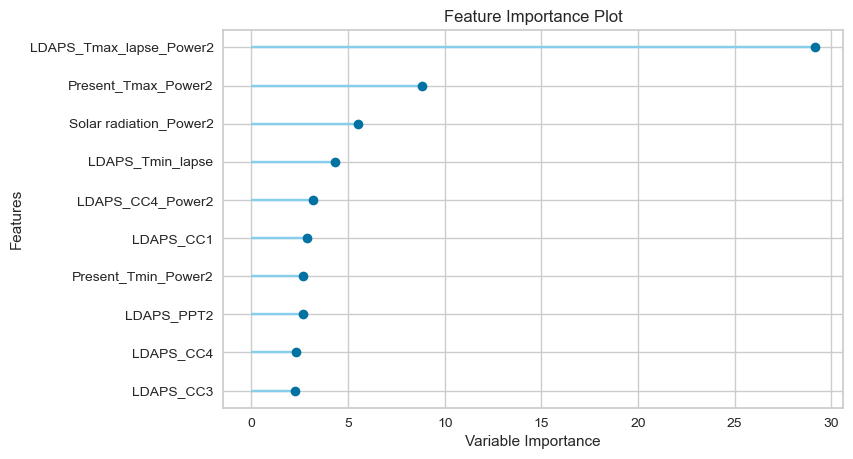

In [8]:
plot_model(top3[0], plot='feature')

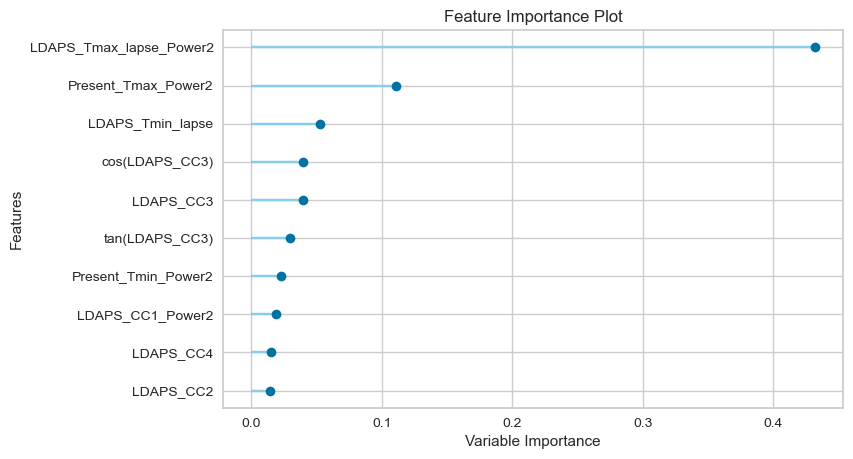

In [9]:
plot_model(top3[1], plot='feature')

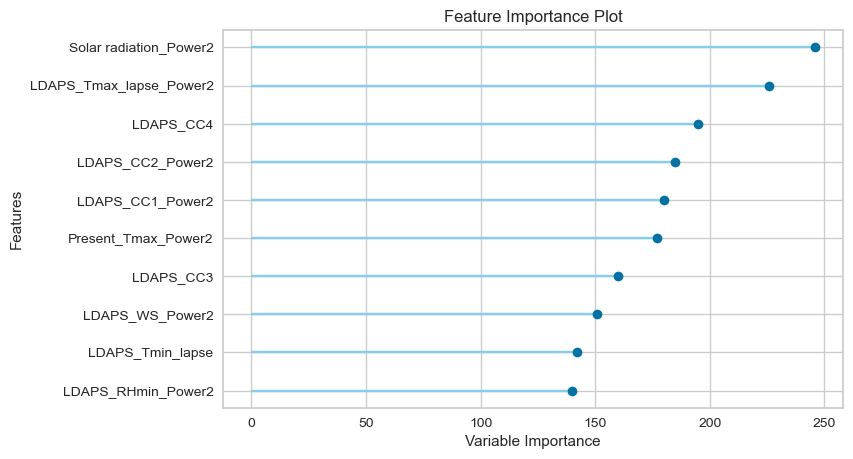

In [10]:
plot_model(top3[2], plot='feature')

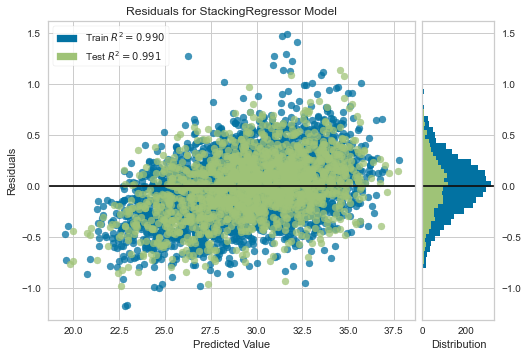

In [11]:
plot_model(model, plot='residuals')

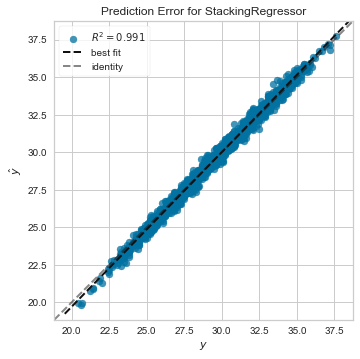

In [12]:
plot_model(model, plot='error')

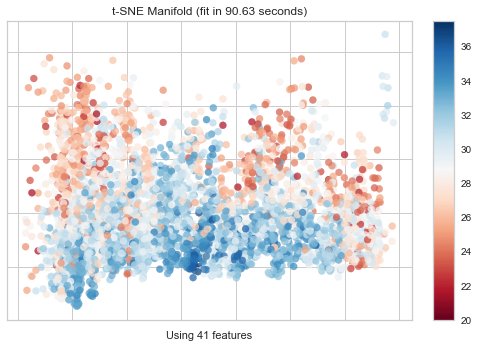

In [13]:
plot_model(model, plot='manifold')

# Predição de conjunto de dados não vistos
* O resultado dessa predição irá definir nosso desempenho final.
* Podemos observar como a qualidade dos resultados é bastante superior ao modelo original (melhor em >80% das predições)
* Comparando-se com o paper que baseou o modelo original podemos observar como nossos resultados de R^2 e RMSE se mostraram bastante superiores.
    * [R^2] Paper original: 0.75-0.78 | Modelo proposto: 0.95
    * [RMSE] Paper original: 1.55-1.66 | Modelo Proposto: 0.65
* Finalmente, podemos observar valores bastante altos para precisão e revocação em relação à variável binária "hotter", que define se o dia seguinte será mais quente que o atual.

In [14]:
predictions = predict_model(model, data = data_unseen)

In [15]:
r2_score(predictions.Shifted_Tmax, predictions.Label)

0.950860336006579

In [16]:
mean_squared_error(predictions.Shifted_Tmax, predictions.Label, squared=False)

0.6503038547151463

In [17]:
predictions['mod_original'] = abs(predictions.Original_Model_Tmax - predictions.Shifted_Tmax)
predictions['mod_label'] = abs(predictions.Label - predictions.Shifted_Tmax)

In [18]:
(predictions.mod_label < predictions.mod_original).sum() / predictions.shape[0]

0.8449653702717101

In [19]:
predictions['hotter_true'] = predictions.Shifted_Tmax > predictions.Present_Tmax
predictions['hotter_pred'] = predictions.Label > predictions.Present_Tmax

In [20]:
confusion_matrix(predictions.hotter_true, predictions.hotter_pred)

array([[869,  96],
       [ 84, 828]], dtype=int64)

In [21]:
precision_score(predictions.hotter_true, predictions.hotter_pred)

0.8961038961038961

In [22]:
recall_score(predictions.hotter_true, predictions.hotter_pred)

0.9078947368421053

# Salvando o modelo final

In [23]:
save_model(model, './../models/summer_weather_300122.sav')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Next_Tmax', 'Next_Tmin',
                                                        'Original_Model_Tmax',
                                                        'Original_Model_Tmin'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Shifted_Tmax',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=L...
                                                               min_child_weight=0.001,
                                                               min_split_gain=0.0,
               